In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import os


In [2]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Print working directory
print(f"Current working directory: {os.getcwd()}")

Device: cuda
Current working directory: e:\ESE-5460\final\golf-pose-preprocessing


In [3]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((160, 160*8)),  # Resize to 80x(80*8)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load datasets
data_dir = "datafolder"
train_dir = os.path.join(data_dir, "frames_without_bg_train_dataset")
test_dir = os.path.join(data_dir, "frames_without_bg_test_dataset")

# Print dataset directories
print(f"Train dataset directory: {train_dir}")
print(f"Test dataset directory: {test_dir}")

# Check if directories exist
if not os.path.exists(train_dir):
    print(f"Train directory does not exist: {train_dir}")
if not os.path.exists(test_dir):
    print(f"Test directory does not exist: {test_dir}")

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Train dataset directory: datafolder\frames_without_bg_train_dataset
Test dataset directory: datafolder\frames_without_bg_test_dataset


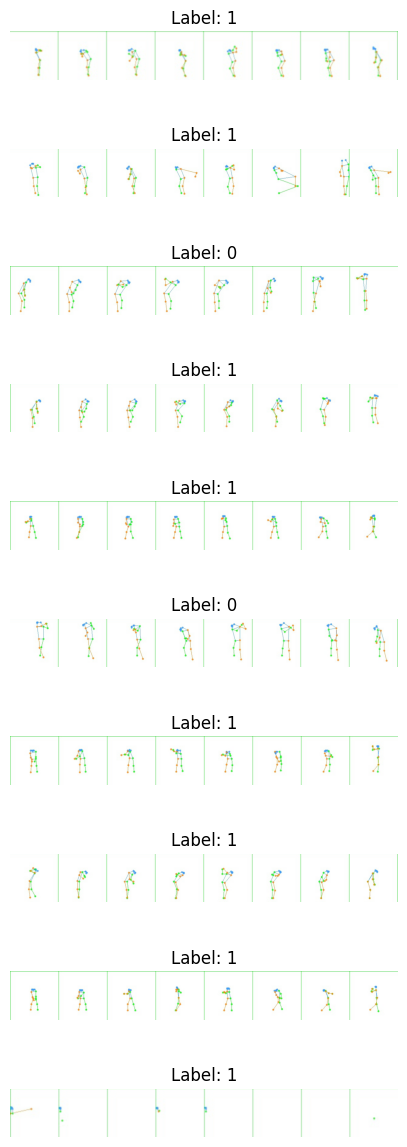

In [ ]:
import matplotlib.pyplot as plt
import random

def show_sample_images(dataset, num_samples=10):
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(num_samples, 1, figsize=(5, 15))
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0)  # Move channel dimension to the end
        image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
        image = image.numpy()
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

# Show sample images from the training dataset
show_sample_images(train_dataset)

In [5]:
# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, writer=None):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        if writer:
            writer.add_scalar("Loss/train", epoch_loss, epoch)
            writer.add_scalar("Accuracy/train", epoch_acc, epoch)
            writer.flush()

    if writer:
        writer.close()

In [6]:

# Load pretrained ResNet
model = models.resnet18(pretrained=True)  # Use ResNet18; you can also choose ResNet50
num_features = model.fc.in_features  # Number of features in the final layer
model.fc = nn.Linear(num_features, 2)  # Modify the final layer to output 2 classes (good/bad)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

writer = SummaryWriter("runs/golf_swing_classification")

train_model(model, train_loader, criterion, optimizer, num_epochs=10, writer=writer)

c:\ProgramData\miniconda3\envs\mmpose\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\miniconda3\envs\mmpose\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.5155, Accuracy: 0.8050
Epoch [2/10], Loss: 0.1400, Accuracy: 0.9381
Epoch [3/10], Loss: 0.2402, Accuracy: 0.9814
Epoch [4/10], Loss: 0.0729, Accuracy: 0.9783
Epoch [5/10], Loss: 0.2209, Accuracy: 0.9443
Epoch [6/10], Loss: 0.0899, Accuracy: 0.9690
Epoch [7/10], Loss: 0.0528, Accuracy: 0.9845
Epoch [8/10], Loss: 0.0507, Accuracy: 0.9814
Epoch [9/10], Loss: 0.0580, Accuracy: 0.9876
Epoch [10/10], Loss: 0.0128, Accuracy: 0.9969


In [9]:
# Save the model
torch.save(model.state_dict(), "golf_swing_classification.pth")

# Test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {correct / total:.4f}")

test_model(model, test_loader)

Test Accuracy: 0.9612


In [10]:
# Release GPU memory and shutdown Jupyter Notebook
import os
os.system("nvidia-smi")
os._exit(00)

: 